<a href="https://colab.research.google.com/github/SSNEGI05/portfolio_analysis/blob/main/Portfolio_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import Libraries
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
!pip install squarify -q
import squarify
!pip install pyportfolioopt -q
from datetime import datetime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 9.3 MB/s eta 0:00:00


In [2]:
# INPUT SECTION (Adjust here) ---
# Format: 'Ticker': [Average_Buy_Price, Quantity]
portfolio_data = {
    'ANANTRAJ.NS': [595.72, 22],
    'BHARTIARTL.NS': [2000.05, 6],
    'BSE.NS':     [2440.40 , 2],
    'CDSL.NS': [1490.06, 3],
    'ETERNAL.NS': [286.24, 30],
    'GROWW.NS': [100.00, 100],
    'LT.NS': [3947.23, 3],
    'NIFTYBEES.NS': [289.33, 47],
    'NSDL.NS': [1065.91, 4]
}
df = pd.DataFrame.from_dict(portfolio_data, orient='index', columns=['Avg_Price', 'Quantity'])
df.index.name = 'Ticker'

print("Current Portfolio:")
print(df)

Current Portfolio:
               Avg_Price  Quantity
Ticker                            
ANANTRAJ.NS       595.72        22
BHARTIARTL.NS    2000.05         6
BSE.NS           2440.40         2
CDSL.NS          1490.06         3
ETERNAL.NS        286.24        30
GROWW.NS          100.00       100
LT.NS            3947.23         3
NIFTYBEES.NS      289.33        47
NSDL.NS          1065.91         4


In [3]:
# Fetch Prices
tickers_list = df.index.tolist()
print(f"Fetching current prices for: {tickers_list}...")


data = yf.download(tickers_list, period="1d", auto_adjust=False, progress=False, group_by='ticker')

current_prices = {}
missing_tickers = []

for ticker in tickers_list:
    try:
        if isinstance(data.columns, pd.MultiIndex):
            price_series = data[ticker]['Close']
        else:
            if ticker == tickers_list[0]:
                 price_series = data['Close']
            else:
                 raise KeyError


        last_price = price_series.iloc[-1]


        if pd.isna(last_price):
            missing_tickers.append(ticker)
            current_prices[ticker] = np.nan
        else:
            current_prices[ticker] = last_price

    except (KeyError, IndexError):
        missing_tickers.append(ticker)
        current_prices[ticker] = np.nan

df['Current_Price'] = pd.Series(current_prices)
df['Invested_Value'] = df['Avg_Price'] * df['Quantity']
df['Current_Value']  = df['Current_Price'] * df['Quantity']
df['PnL']            = df['Current_Value'] - df['Invested_Value']
df['PnL_%']          = (df['PnL'] / df['Invested_Value']) * 100

pd.options.display.float_format = '{:,.2f}'.format
valid_df = df.dropna(subset=['Current_Value'])

total_invested = valid_df['Invested_Value'].sum()
total_current  = valid_df['Current_Value'].sum()
total_pnl      = valid_df['PnL'].sum()
total_pnl_pct  = (total_pnl / total_invested) * 100 if total_invested > 0 else 0

# --- OUTPUT ---
print("\n" + "="*50)
print(" PORTFOLIO DETAILED VIEW")
print("="*50)
# Show the full dataframe so you can see which one has NaN
print(df[['Quantity', 'Avg_Price', 'Current_Price', 'Invested_Value', 'Current_Value', 'PnL', 'PnL_%']])

print("\n" + "="*50)
print(f" TOTAL PORTFOLIO SUMMARY (Excluding missing stocks)")
print("="*50)

if missing_tickers:
    print(f"⚠️  WARNING: Could not fetch price for: {missing_tickers}")
    print(f"   -> Suggestion: Try changing '.NS' to '.BO' in Cell 2.")
    print(f"   -> Note: These stocks are excluded from the Total Summary below.\n")

print(f" Total Invested:  ₹ {total_invested:,.2f}")
print(f" Current Value:   ₹ {total_current:,.2f}")
print(f" Total P&L:       ₹ {total_pnl:,.2f} ({total_pnl_pct:+.2f}%)")
print("="*50)

Fetching current prices for: ['ANANTRAJ.NS', 'BHARTIARTL.NS', 'BSE.NS', 'CDSL.NS', 'ETERNAL.NS', 'GROWW.NS', 'LT.NS', 'NIFTYBEES.NS', 'NSDL.NS']...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NSDL.NS']: YFPricesMissingError('possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")')



 PORTFOLIO DETAILED VIEW
               Quantity  Avg_Price  Current_Price  Invested_Value  \
Ticker                                                              
ANANTRAJ.NS          22     595.72         548.70       13,105.84   
BHARTIARTL.NS         6   2,000.05       1,977.40       12,000.30   
BSE.NS                2   2,440.40       2,739.50        4,880.80   
CDSL.NS               3   1,490.06       1,320.40        4,470.18   
ETERNAL.NS           30     286.24         269.45        8,587.20   
GROWW.NS            100     100.00         169.16       10,000.00   
LT.NS                 3   3,947.23       4,380.60       11,841.69   
NIFTYBEES.NS         47     289.33         289.23       13,598.51   
NSDL.NS               4   1,065.91            NaN        4,263.64   

               Current_Value       PnL  PnL_%  
Ticker                                         
ANANTRAJ.NS        12,071.40 -1,034.44  -7.89  
BHARTIARTL.NS      11,864.40   -135.90  -1.13  
BSE.NS              5,

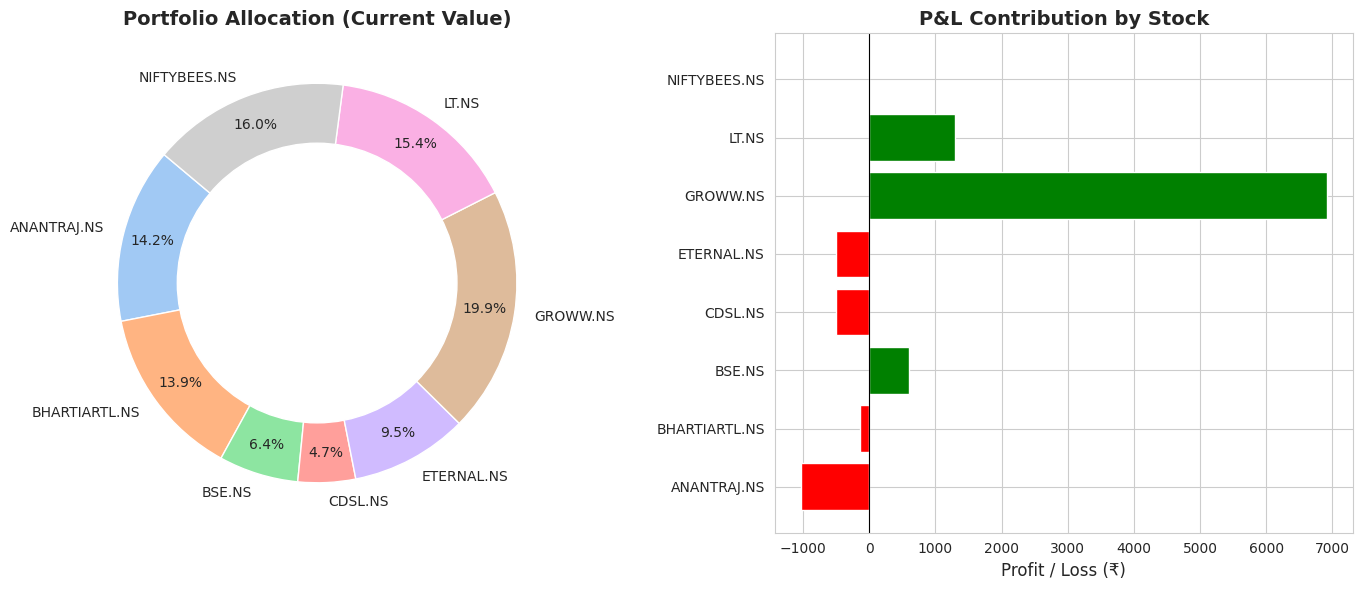

In [4]:
# Visual Analytics
plot_df = df.dropna(subset=['Current_Value', 'PnL'])

# Check if we have data to plot
if plot_df.empty:
    print("No valid data to plot. Please check your ticker symbols.")
else:
    # Set the visual style
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    colors = sns.color_palette('pastel')

    plt.pie(plot_df['Current_Value'], labels=plot_df.index, autopct='%1.1f%%', startangle=140, colors=colors, pctdistance=0.85)
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    plt.title('Portfolio Allocation (Current Value)', fontsize=14, fontweight='bold')


    plt.subplot(1, 2, 2)


    pnl_colors = ['green' if x >= 0 else 'red' for x in plot_df['PnL']]
    bars = plt.barh(plot_df.index, plot_df['PnL'], color=pnl_colors)
    plt.xlabel('Profit / Loss (₹)', fontsize=12)
    plt.title('P&L Contribution by Stock', fontsize=14, fontweight='bold')
    plt.axvline(0, color='black', linewidth=0.8) # Add a line at 0
    plt.tight_layout()
    plt.show()

Fetching 1-year history for correlation analysis...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NSDL.NS']: YFPricesMissingError('possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


⚠️ Dropped these stocks (no data): ['NSDL.NS']


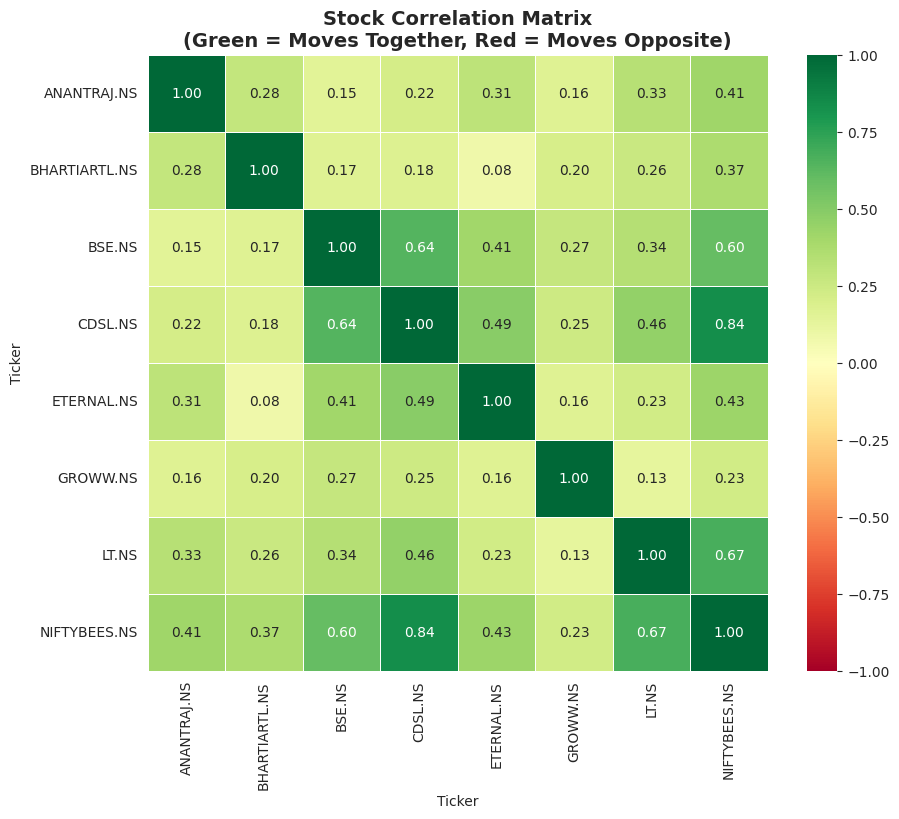

In [5]:
#  Risk Analysis - Correlation Matrix
import seaborn as sns
tickers_list = df.index.tolist()
print(f"Fetching 1-year history for correlation analysis...")

history = yf.download(tickers_list, period="1y", auto_adjust=False, progress=False)['Close']

valid_history = history.dropna(axis=1, how='all')

dropped_stocks = list(set(tickers_list) - set(valid_history.columns))
if dropped_stocks:
    print(f"⚠️ Dropped these stocks (no data): {dropped_stocks}")

daily_returns = valid_history.pct_change(fill_method=None).dropna()

correlation_matrix = daily_returns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='RdYlGn',
            vmin=-1, vmax=1,
            fmt='.2f',
            linewidths=0.5)

plt.title('Stock Correlation Matrix\n(Green = Moves Together, Red = Moves Opposite)', fontsize=14, fontweight='bold')
plt.show()

Fetching data for Portfolio + Nifty 50...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NSDL.NS']: YFPricesMissingError('possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


⚠️ Dropped these stocks (no data): ['NSDL.NS']


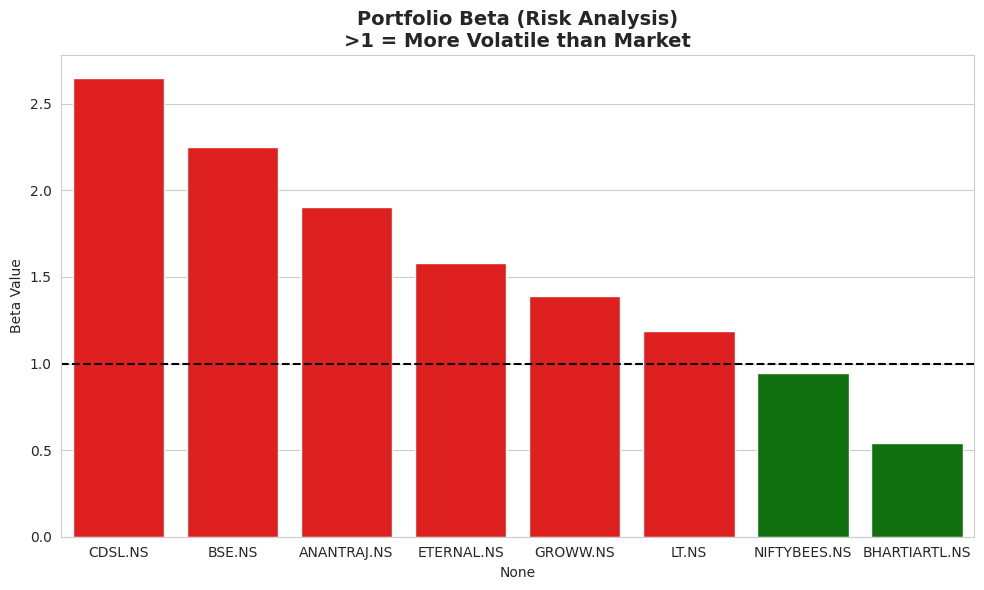


--- Beta Values ---
               Beta
CDSL.NS        2.65
BSE.NS         2.25
ANANTRAJ.NS    1.91
ETERNAL.NS     1.58
GROWW.NS       1.39
LT.NS          1.19
NIFTYBEES.NS   0.95
BHARTIARTL.NS  0.54


In [6]:
# Calculate Beta

"""import logging

# 1. Silence the ugly yfinance errors
logger = logging.getLogger('yfinance')
logger.disabled = True
logger.setLevel(logging.CRITICAL)"""


benchmark = '^NSEI'
tickers_list = df.index.tolist()

print(f"Fetching data for Portfolio + Nifty 50...")
download_list = tickers_list + [benchmark]
data = yf.download(download_list, period="1y", auto_adjust=False, progress=False)['Close']

data = data.dropna(axis=1, how='all')
dropped_stocks = list(set(download_list) - set(data.columns))
if dropped_stocks:
    print(f"⚠️ Dropped these stocks (no data): {dropped_stocks}")

if benchmark not in data.columns:
    print("❌ Error: Benchmark (^NSEI) failed to download. Cannot calculate Beta.")
else:
    returns = data.pct_change(fill_method=None).dropna()

    market_returns = returns[benchmark]
    market_var = market_returns.var()

    betas = {}


    valid_tickers = [t for t in data.columns if t != benchmark]

    for ticker in valid_tickers:
        cov = returns[ticker].cov(market_returns)
        if market_var > 0:
            beta_val = cov / market_var
            betas[ticker] = beta_val
        else:
            betas[ticker] = 0
    beta_df = pd.DataFrame.from_dict(betas, orient='index', columns=['Beta'])

    if not beta_df.empty:
        beta_df = beta_df.sort_values(by='Beta', ascending=False)

        plt.figure(figsize=(10, 6))

        colors = ['red' if x > 1 else 'green' for x in beta_df['Beta']]

        sns.barplot(x=beta_df.index, y=beta_df['Beta'], hue=beta_df.index, palette=colors, legend=False)

        plt.axhline(1, color='black', linestyle='--', label='Market Average (1.0)')
        plt.title('Portfolio Beta (Risk Analysis)\n>1 = More Volatile than Market', fontsize=14, fontweight='bold')
        plt.ylabel('Beta Value')
        plt.tight_layout()
        plt.show()

        print("\n--- Beta Values ---")
        print(beta_df)
    else:
        print("No valid data to calculate Beta.")

Calculating potential impact based on Portfolio Beta...
⚠️ Note: Excluded 1 stock(s) (like NSDL) from Stress Test due to missing Beta/Price data.

 STRESS TEST REPORT (Analyzed Value: ₹85,111.11)
              Projected_Total_Value  Projected_PnL_Impact  \
Market Crash              67,568.14            -17,542.97   
Correction                79,263.45             -5,847.66   
Bull Run                  96,806.43             11,695.32   

              %_Impact_on_Portfolio  
Market Crash                 -20.61  
Correction                    -6.87  
Bull Run                      13.74  


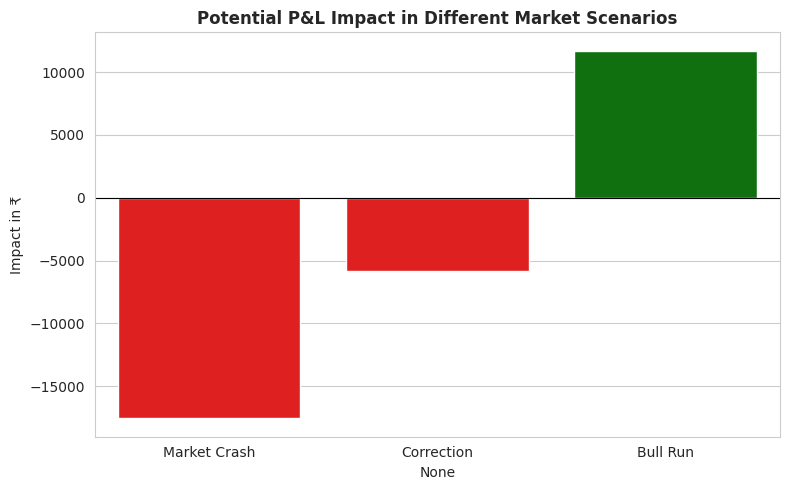

In [7]:
# Scenario Analysis

# --- USER INPUT: Define Scenarios ---
scenarios = {
    'Market Crash': -0.15,  # Market falls 15%
    'Correction':   -0.05,  # Market falls 5%
    'Bull Run':      0.10   # Market rises 10%
}
# ---------------------------------------------------------------

print("Calculating potential impact based on Portfolio Beta...")

impact_df = pd.DataFrame(index=df.index)
impact_df['Current_Value'] = df['Current_Value']
impact_df['Beta'] = beta_df['Beta']

stocks_before = len(impact_df)
impact_df = impact_df.dropna(subset=['Beta', 'Current_Value'])
stocks_after = len(impact_df)

if stocks_before > stocks_after:
    dropped = stocks_before - stocks_after
    print(f"⚠️ Note: Excluded {dropped} stock(s) (like NSDL) from Stress Test due to missing Beta/Price data.")

scenario_results = {}

test_portfolio_value = impact_df['Current_Value'].sum()

for scenario_name, market_change in scenarios.items():
    stock_moves = impact_df['Beta'] * market_change
    projected_values = impact_df['Current_Value'] * (1 + stock_moves)

    total_projected_value = projected_values.sum()
    impact_pnl = total_projected_value - test_portfolio_value
    scenario_results[scenario_name] = impact_pnl

stress_test_df = pd.DataFrame.from_dict(scenario_results, orient='index', columns=['Projected_PnL_Impact'])

stress_test_df['Projected_Total_Value'] = test_portfolio_value + stress_test_df['Projected_PnL_Impact']
stress_test_df['%_Impact_on_Portfolio'] = (stress_test_df['Projected_PnL_Impact'] / test_portfolio_value) * 100


pd.options.display.float_format = '{:,.2f}'.format

print("\n" + "="*60)
print(f" STRESS TEST REPORT (Analyzed Value: ₹{test_portfolio_value:,.2f})")
print("="*60)
print(stress_test_df[['Projected_Total_Value', 'Projected_PnL_Impact', '%_Impact_on_Portfolio']])

if not stress_test_df.empty:
    plt.figure(figsize=(8, 5))
    colors = ['red' if x < 0 else 'green' for x in stress_test_df['Projected_PnL_Impact']]

    sns.barplot(x=stress_test_df.index,
                y=stress_test_df['Projected_PnL_Impact'],
                hue=stress_test_df.index,
                palette=colors,
                legend=False)

    plt.title('Potential P&L Impact in Different Market Scenarios', fontsize=12, fontweight='bold')
    plt.ylabel('Impact in ₹')
    plt.axhline(0, color='black', linewidth=0.8)
    plt.tight_layout()
    plt.show()
else:
    print("No data available for stress testing.")

Fetching latest Sector data dynamically...


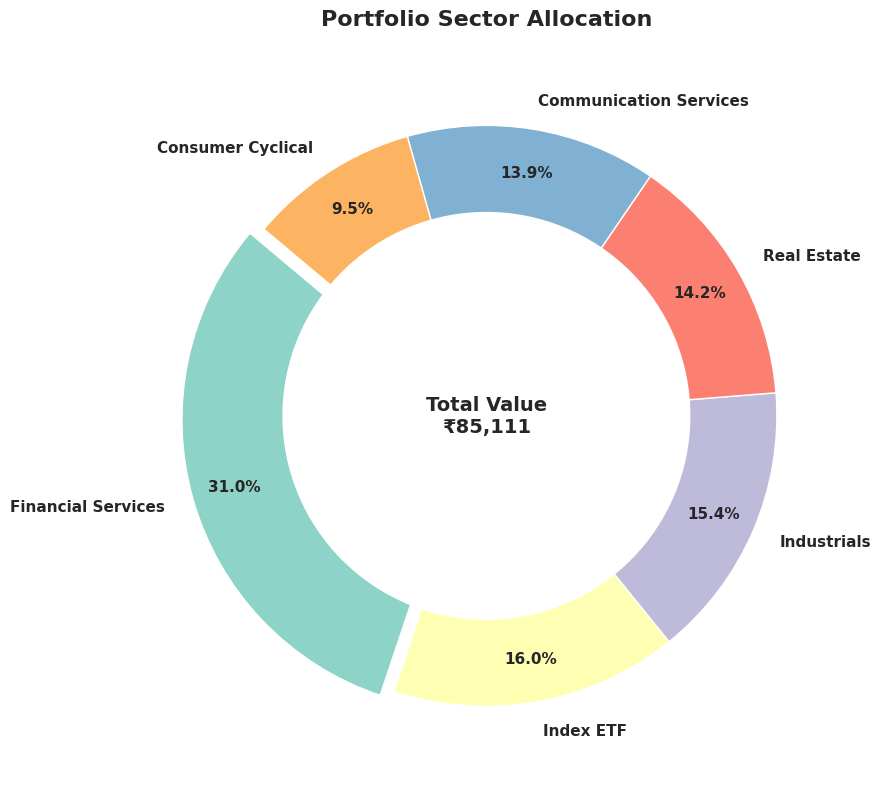


--- SECTOR BREAKDOWN ---


,Sector,Current_Value,Weight_%
2,Financial Services,"26,356.20",30.97
3,Index ETF,"13,593.81",15.97
4,Industrials,"13,141.80",15.44
5,Real Estate,"12,071.40",14.18
0,Communication Services,"11,864.40",13.94
1,Consumer Cyclical,"8,083.50",9.50


In [8]:
# Premium Sector Allocation


print("Fetching latest Sector data dynamically...")
sector_data = {}
tickers_list = df.index.tolist()

for ticker in tickers_list:
    try:
        stock = yf.Ticker(ticker)
        sector = stock.info.get('sector', 'Unknown')
        if 'BEES' in ticker.upper():
            sector = 'Index ETF'

        sector_data[ticker] = sector
    except Exception:
        sector_data[ticker] = 'Unknown'
df['Sector'] = df.index.map(sector_data)

sector_df = df.groupby('Sector')['Current_Value'].sum().reset_index()

sector_df = sector_df[sector_df['Current_Value'] > 0].copy()

total_portfolio_value = sector_df['Current_Value'].sum()
sector_df['Weight_%'] = (sector_df['Current_Value'] / total_portfolio_value) * 100

sector_df = sector_df.sort_values(by='Weight_%', ascending=False)

THRESHOLD = 5.0
major_sectors = sector_df[sector_df['Weight_%'] >= THRESHOLD].copy()
minor_sectors = sector_df[sector_df['Weight_%'] < THRESHOLD]

if not minor_sectors.empty:
    others_value = minor_sectors['Current_Value'].sum()
    others_weight = minor_sectors['Weight_%'].sum()

    others_df = pd.DataFrame([{'Sector': 'Others', 'Current_Value': others_value, 'Weight_%': others_weight}])

    plot_data = pd.concat([major_sectors, others_df], ignore_index=True)
else:
    plot_data = major_sectors

if not plot_data.empty:
    plt.figure(figsize=(10, 8))

    colors = plt.cm.Set3.colors
    explode = [0.05 if i == 0 else 0 for i in range(len(plot_data))]

    wedges, texts, autotexts = plt.pie(
        plot_data['Current_Value'],
        labels=plot_data['Sector'],
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        explode=explode,
        pctdistance=0.85, # Move percentages slightly outward
        textprops={'fontsize': 11, 'fontweight': 'bold'}
    )

    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.text(0, 0, f"Total Value\n₹{total_portfolio_value:,.0f}", ha='center', va='center', fontsize=14, fontweight='bold')

    plt.title('Portfolio Sector Allocation', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

    print("\n--- SECTOR BREAKDOWN ---")
    display(plot_data[['Sector', 'Current_Value', 'Weight_%']].round(2))
else:
    print("⚠️ No valid data to plot.")

In [9]:
# The Ultimate Optimization Arena

from scipy.optimize import minimize
from pypfopt import expected_returns, risk_models
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.hierarchical_portfolio import HRPOpt
import warnings
warnings.filterwarnings("ignore")

# =====================================================================
# --- ADJUSTABLE PARAMETERS ---
# =====================================================================
HISTORY_PERIOD = "2y"    # Length of history to download
MAX_WEIGHT = 0.15        # Maximum allocation per stock (15%)
MIN_WEIGHT = 0.02        # Minimum allocation per stock (2%)
# =====================================================================

print(f"Fetching {HISTORY_PERIOD} of data to run the Ultimate Arena...")
def enforce_constraints(weights, min_w, max_w):
    w = pd.Series(weights).copy()
    for _ in range(10):
        over = w > max_w + 1e-5
        under = w < min_w - 1e-5
        if not over.any() and not under.any():
            break
        w[over] = max_w
        w[under] = min_w
        free = ~(over | under)
        if free.any():
            target_sum = 1.0 - w[~free].sum()
            w[free] = w[free] / w[free].sum() * target_sum
    return w

tickers_list = df.index.tolist()
data = yf.download(tickers_list, period=HISTORY_PERIOD, auto_adjust=False, progress=False)['Close']
data = data.dropna(axis=1, how='all').ffill()
valid_tickers = data.columns.tolist()

# Calculate Current Weights
current_total = sum([df.loc[t, 'Quantity'] * df.loc[t, 'Current_Price'] for t in valid_tickers if t in df.index])
current_weights = {t: (df.loc[t, 'Quantity'] * df.loc[t, 'Current_Price']) / current_total for t in valid_tickers if t in df.index}

daily_returns = data.pct_change()
mu = daily_returns.mean() * 252
S_raw = daily_returns.cov() * 252
S = risk_models.fix_nonpositive_semidefinite(S_raw)

ef_sharpe = EfficientFrontier(mu, S, weight_bounds=(MIN_WEIGHT, MAX_WEIGHT))
try:
    ef_sharpe.max_sharpe()
    weights_sharpe = ef_sharpe.clean_weights()
except:
    weights_sharpe = {t: 0 for t in valid_tickers}

ef_minvol = EfficientFrontier(mu, S, weight_bounds=(MIN_WEIGHT, MAX_WEIGHT))
try:
    ef_minvol.min_volatility()
    weights_minvol = ef_minvol.clean_weights()
except:
    weights_minvol = {t: 0 for t in valid_tickers}

volatilities = daily_returns.std() * np.sqrt(252)
inv_vol = 1.0 / volatilities
risk_parity_raw = inv_vol / inv_vol.sum()


risk_parity_final = enforce_constraints(risk_parity_raw, MIN_WEIGHT, MAX_WEIGHT)
weights_rp = risk_parity_final.to_dict()

def calc_max_div(cov_matrix, min_w, max_w):
    num_assets = len(cov_matrix)
    vols = np.sqrt(np.diag(cov_matrix))
    def objective(w):
        port_vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
        w_vol = np.dot(w, vols)
        return -(w_vol / port_vol)

    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0}]
    bounds = tuple((min_w, max_w) for _ in range(num_assets))
    init_guess = np.array([1.0 / num_assets] * num_assets)
    res = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    return res.x if res.success else init_guess

max_div_array = calc_max_div(S.values, MIN_WEIGHT, MAX_WEIGHT)
weights_maxdiv = {valid_tickers[i]: max_div_array[i] for i in range(len(valid_tickers))}

try:
    clean_returns = daily_returns.dropna()
    hrp = HRPOpt(clean_returns)
    weights_hrp = hrp.optimize()
except:
    weights_hrp = {t: 0 for t in valid_tickers}

comparison_df = pd.DataFrame({
    'Current_%': pd.Series(current_weights) * 100,
    'MVO_Sharpe_%': pd.Series(weights_sharpe) * 100,
    'Min_Vol_%': pd.Series(weights_minvol) * 100,
    'Risk_Parity_%': pd.Series(weights_rp) * 100,
    'Max_Div_%': pd.Series(weights_maxdiv) * 100,
    'HRP_(ML)_%': pd.Series(weights_hrp) * 100
}).fillna(0)

comparison_df = comparison_df.round(2)

print("\n" + "="*90)
print(f" 🏆 THE ULTIMATE OPTIMIZATION ARENA (Fixed Constraints: Max {MAX_WEIGHT*100}%)")
print("="*90)
display(comparison_df)

Fetching 2y of data to run the Ultimate Arena...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NSDL.NS']: YFPricesMissingError('possibly delisted; no price data found  (period=2y) (Yahoo error = "No data found, symbol may be delisted")')



 🏆 THE ULTIMATE OPTIMIZATION ARENA (Fixed Constraints: Max 15.0%)


,Current_%,MVO_Sharpe_%,Min_Vol_%,Risk_Parity_%,Max_Div_%,HRP_(ML)_%
ANANTRAJ.NS,14.18,7.14,8.26,10.12,9.39,2.60
BHARTIARTL.NS,13.94,15.00,15.00,15.00,15.00,31.69
BSE.NS,6.44,15.00,6.30,9.71,9.46,2.85
CDSL.NS,4.65,2.86,15.00,12.99,6.40,3.55
ETERNAL.NS,9.50,15.00,15.00,13.99,15.00,4.22
GROWW.NS,19.88,15.00,10.44,8.19,14.74,1.55
LT.NS,15.44,15.00,15.00,15.00,15.00,13.63
NIFTYBEES.NS,15.97,15.00,15.00,15.00,15.00,39.92


In [10]:
# The Fundamental Arena

# =====================================================================
# --- ADJUSTABLE PARAMETERS ---
# =====================================================================
MAX_WEIGHT = 0.15        # Maximum allocation per stock (15%)
MIN_WEIGHT = 0.02        # Minimum allocation per stock (2%)
DEFAULT_PE = 100         # Penalty for missing/negative P/E
# =====================================================================

print("Fetching Smart Fundamental Data (P/E & ROE) and fixing constraints...")

def enforce_constraints(weights, min_w, max_w):
    w = pd.Series(weights).copy()
    for _ in range(10):  # Run a few times to smooth out the waterfall
        over = w > max_w + 1e-5
        under = w < min_w - 1e-5
        if not over.any() and not under.any():
            break
        w[over] = max_w
        w[under] = min_w
        free = ~(over | under)
        if free.any():
            target_sum = 1.0 - w[~free].sum()
            w[free] = w[free] / w[free].sum() * target_sum
    return w

valid_tickers = [t for t in df.index if t != 'NSDL.NS']
fund_data = []

for ticker in valid_tickers:
    try:
        stock = yf.Ticker(ticker)
        info = stock.info

        pe = info.get('trailingPE', np.nan)
        if pd.isna(pe) or pe <= 0:
            pe = DEFAULT_PE

        roe = info.get('returnOnEquity', np.nan)
        if pd.isna(roe):
            eps = info.get('trailingEps', np.nan)
            book_value = info.get('bookValue', np.nan)
            if not pd.isna(eps) and not pd.isna(book_value) and book_value > 0:
                roe = eps / book_value
            else:
                roe = 0.10

        if 'BEES' in ticker.upper():
            roe = 0.12
            pe = info.get('navPrice', 20)

        fund_data.append({'Ticker': ticker, 'P/E': pe, 'ROE': roe})
    except Exception as e:
        fund_data.append({'Ticker': ticker, 'P/E': DEFAULT_PE, 'ROE': 0.10})

fund_df = pd.DataFrame(fund_data).set_index('Ticker')


current_total = sum([df.loc[t, 'Quantity'] * df.loc[t, 'Current_Price'] for t in valid_tickers if t in df.index])
current_weights = {t: (df.loc[t, 'Quantity'] * df.loc[t, 'Current_Price']) / current_total for t in valid_tickers if t in df.index}

fund_df['Earnings_Yield'] = 1 / fund_df['P/E']
raw_ey_weights = fund_df['Earnings_Yield'] / fund_df['Earnings_Yield'].sum()
ey_weights_final = enforce_constraints(raw_ey_weights, MIN_WEIGHT, MAX_WEIGHT)


fund_df['Yield_Rank'] = fund_df['Earnings_Yield'].rank(ascending=True)
fund_df['ROE_Rank'] = fund_df['ROE'].rank(ascending=True)
fund_df['Fundamental_Score'] = fund_df['Yield_Rank'] + fund_df['ROE_Rank']

raw_vq_weights = fund_df['Fundamental_Score'] / fund_df['Fundamental_Score'].sum()
vq_weights_final = enforce_constraints(raw_vq_weights, MIN_WEIGHT, MAX_WEIGHT)

fund_df['Current_%'] = pd.Series(current_weights) * 100
fund_df['Earnings_Yield_%'] = ey_weights_final * 100
fund_df['Value_Quality_%'] = vq_weights_final * 100

display_df = fund_df[['P/E', 'ROE', 'Current_%', 'Earnings_Yield_%', 'Value_Quality_%']].copy()
display_df['ROE'] = (display_df['ROE'] * 100).round(2).astype(str) + '%'
display_df = display_df.round(2)

print("\n" + "="*85)
print(f" 🏦 THE FUNDAMENTAL ARENA (Fixed Math & Smart Data)")
print("="*85)
display(display_df)

Fetching Smart Fundamental Data (P/E & ROE) and fixing constraints...

 🏦 THE FUNDAMENTAL ARENA (Fixed Math & Smart Data)


,P/E,ROE,Current_%,Earnings_Yield_%,Value_Quality_%
Ticker,,,,,
ANANTRAJ.NS,36.10,11.86%,14.18,15.00,11.85
BHARTIARTL.NS,39.06,23.12%,13.94,15.00,15.00
BSE.NS,51.82,34.11%,6.44,13.78,15.00
CDSL.NS,57.81,27.39%,4.65,12.35,14.81
ETERNAL.NS,"1,122.71",0.72%,9.50,2.23,2.96
GROWW.NS,61.29,22.39%,19.88,11.65,10.37
LT.NS,34.25,17.36%,15.44,15.00,15.00
NIFTYBEES.NS,20.00,12.0%,15.97,15.00,15.00


In [11]:
# Ensemble Engine & Trade Generator

# =====================================================================
# --- ADJUSTABLE PARAMETERS: YOUR CUSTOM ALGORITHMIC BLEND ---
# =====================================================================
MY_CUSTOM_BLEND = {
    'Value_Quality_%': 0.40,
    'Min_Vol_%': 0.30,
    'Risk_Parity_%': 0.15,
    'MVO_Sharpe_%': 0.05,
    'Earnings_Yield_%': 0.05,
    'Max_Div_%': 0.05,
    'HRP_(ML)_%': 0.00
}

MAX_WEIGHT = 0.15        # Maximum allocation per stock (15%)
MIN_WEIGHT = 0.02        # Minimum allocation per stock (2%)
# =====================================================================

print("Compiling Master Blended Strategy through the Waterfall Checkpoint...\n")

# --- 1. The "Waterfall" Constraint Algorithm ---
def enforce_constraints(weights, min_w, max_w):
    w = pd.Series(weights).copy()
    for _ in range(10):
        over = w > max_w + 1e-5
        under = w < min_w - 1e-5
        if not over.any() and not under.any():
            break
        w[over] = max_w
        w[under] = min_w
        free = ~(over | under)
        if free.any():
            target_sum = 1.0 - w[~free].sum()
            w[free] = w[free] / w[free].sum() * target_sum
    return w

total_blend_weight = sum(MY_CUSTOM_BLEND.values())
if not np.isclose(total_blend_weight, 1.0):
    print(f"⚠️ WARNING: Your custom blend adds up to {total_blend_weight * 100}%, not 100%!")
else:

    try:
        all_targets = pd.concat([comparison_df.drop(columns=['Current_%']), fund_df[['Earnings_Yield_%', 'Value_Quality_%']]], axis=1)
    except NameError:
        print("Error: Could not find previous data. Please run Cell 9 and Cell 10 first!")


    master_target_raw = pd.Series(0.0, index=all_targets.index)

    for model_name, weight in MY_CUSTOM_BLEND.items():
        if model_name in all_targets.columns and weight > 0:
            master_target_raw += (all_targets[model_name] / 100.0) * weight


    master_target_series = enforce_constraints(master_target_raw, MIN_WEIGHT, MAX_WEIGHT)


    total_portfolio_value = df['Current_Value'].sum()
    trades_list = []

    for ticker in master_target_series.index:
        if ticker not in df.index:
            continue

        current_qty = df.loc[ticker, 'Quantity']
        current_price = df.loc[ticker, 'Current_Price']
        current_value = current_qty * current_price

        target_pct = master_target_series[ticker]
        target_value = total_portfolio_value * target_pct
        value_difference = target_value - current_value

        if current_price > 0:
            shares_to_trade = round(value_difference / current_price)
        else:
            shares_to_trade = 0

        actual_trade_value = shares_to_trade * current_price

        if shares_to_trade > 0:
            action = "BUY"
        elif shares_to_trade < 0:
            action = "SELL"
        else:
            action = "HOLD"

        trades_list.append({
            'Ticker': ticker,
            'Action': action,
            'Shares': abs(shares_to_trade),
            'Current_Qty': current_qty,
            'New_Qty': current_qty + shares_to_trade,
            'Target_%': round(target_pct * 100, 2),
            'Trade_Value_₹': abs(actual_trade_value)
        })

    trades_df = pd.DataFrame(trades_list)
    trades_df['Rank'] = trades_df['Action'].map({'BUY': 1, 'HOLD': 2, 'SELL': 3})
    trades_df = trades_df.sort_values(by=['Rank', 'Ticker']).drop(columns=['Rank'])

    print("="*85)
    print(f" 🛡️ MASTER ENSEMBLE TRADE LIST (Waterfall Secured)")
    print("="*85)
    display(trades_df[['Action', 'Shares', 'Ticker', 'Target_%', 'Current_Qty', 'New_Qty', 'Trade_Value_₹']])

    cash_needed = trades_df[trades_df['Action'] == 'BUY']['Trade_Value_₹'].sum()
    cash_freed = trades_df[trades_df['Action'] == 'SELL']['Trade_Value_₹'].sum()
    net_cash = cash_freed - cash_needed

    print("\n--- CASH FLOW ESTIMATE ---")
    print(f"Total Cash Freed by Sells: ₹ {cash_freed:,.2f}")
    print(f"Total Cash Needed to Buy:  ₹ {cash_needed:,.2f}")
    if net_cash >= 0:
        print(f"💰 Net Result: You will have ₹ {net_cash:,.2f} leftover in cash.")
    else:
        print(f"⚠️ Net Result: You need to deposit ₹ {abs(net_cash):,.2f} to execute all trades.")

Compiling Master Blended Strategy through the Waterfall Checkpoint...

 🛡️ MASTER ENSEMBLE TRADE LIST (Waterfall Secured)


,Action,Shares,Ticker,Target_%,Current_Qty,New_Qty,Trade_Value_₹
2,BUY,1,BSE.NS,11.26,2,3,"2,739.50"
3,BUY,6,CDSL.NS,13.45,3,9,"7,922.40"
1,HOLD,0,BHARTIARTL.NS,15.00,6,6,0.00
4,HOLD,0,ETERNAL.NS,9.40,30,30,0.00
6,HOLD,0,LT.NS,15.00,3,3,0.00
0,SELL,6,ANANTRAJ.NS,10.31,22,16,"3,292.20"
5,SELL,47,GROWW.NS,10.58,100,53,"7,950.52"
7,SELL,3,NIFTYBEES.NS,15.00,47,44,867.69



--- CASH FLOW ESTIMATE ---
Total Cash Freed by Sells: ₹ 12,110.41
Total Cash Needed to Buy:  ₹ 10,661.90
💰 Net Result: You will have ₹ 1,448.51 leftover in cash.


Generating Visual Analytics Dashboard...



<Figure size 1200x600 with 0 Axes>

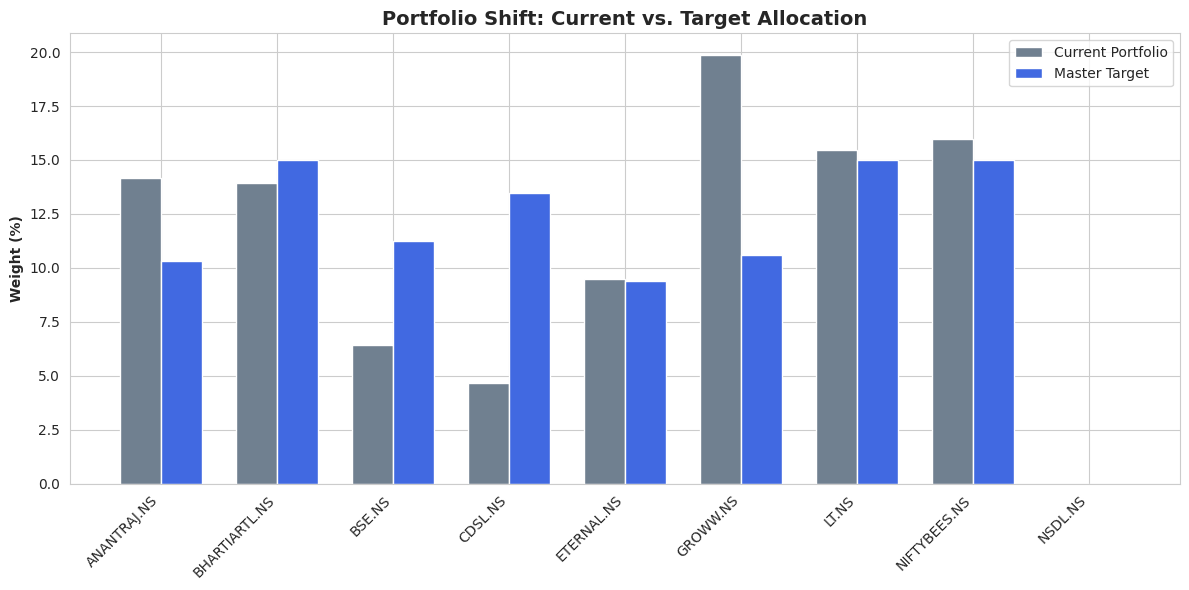

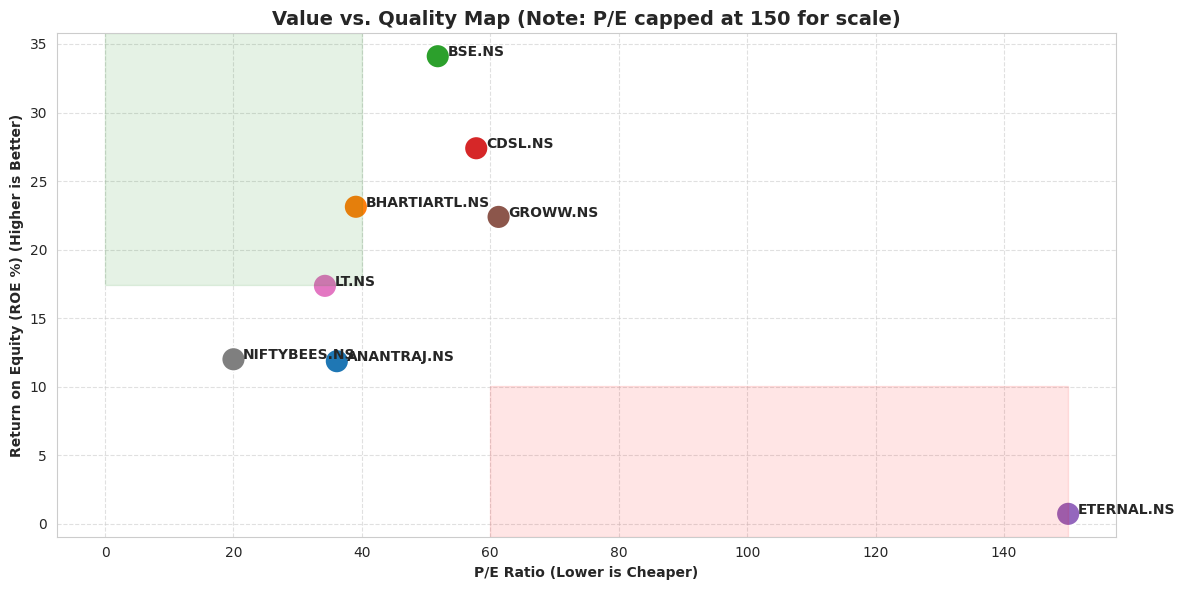

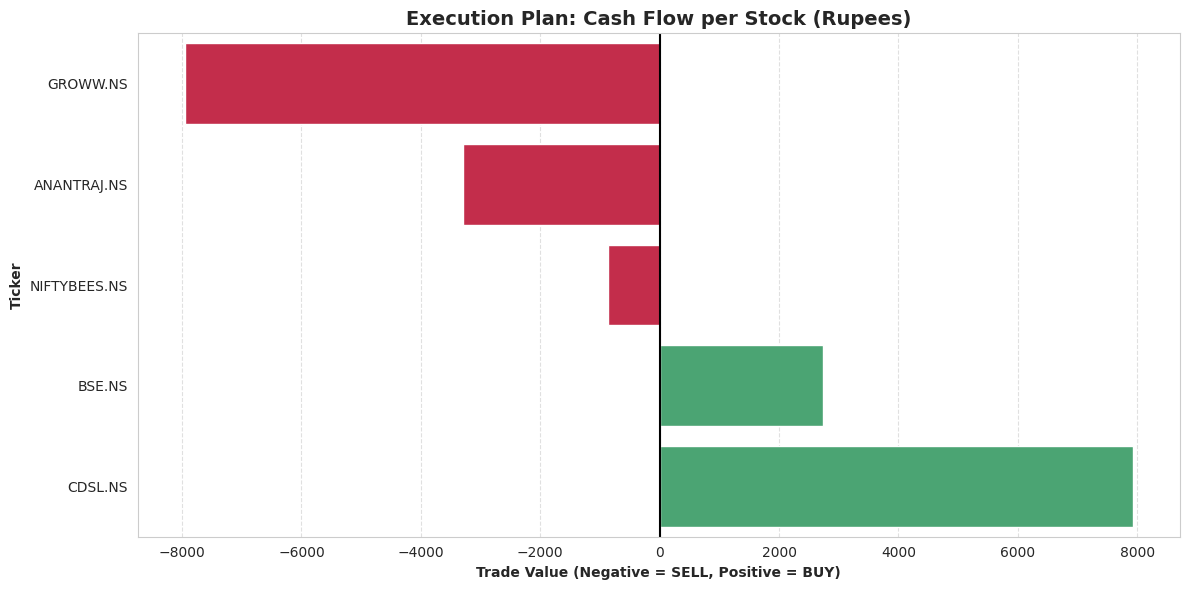

In [12]:
#The Visual Analytics Dashboard

import seaborn as sns

# =====================================================================
# --- ADJUSTABLE PARAMETERS: VISUAL DESIGN ---
# =====================================================================
CHART_STYLE = "whitegrid"  # Options: 'darkgrid', 'whitegrid', 'dark', 'white', 'ticks'
FIG_WIDTH = 12             # Width of the charts
FIG_HEIGHT = 6             # Height of the charts
# =====================================================================

print("Generating Visual Analytics Dashboard...\n")
sns.set_style(CHART_STYLE)

plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))

shift_df = pd.DataFrame({
    'Current %': (df['Current_Value'] / df['Current_Value'].sum() * 100) if 'Current_Value' in df.columns else 0,
    'Target %': master_target_series * 100
}).fillna(0)

x = np.arange(len(shift_df.index))
width = 0.35

fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))
rects1 = ax.bar(x - width/2, shift_df['Current %'], width, label='Current Portfolio', color='slategray')
rects2 = ax.bar(x + width/2, shift_df['Target %'], width, label='Master Target', color='royalblue')

ax.set_ylabel('Weight (%)', fontweight='bold')
ax.set_title('Portfolio Shift: Current vs. Target Allocation', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(shift_df.index, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()

if 'P/E' in fund_df.columns and 'ROE' in fund_df.columns:
    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))


    plot_pe = fund_df['P/E'].clip(upper=150)
    plot_roe = fund_df['ROE'] * 100


    scatter = sns.scatterplot(x=plot_pe, y=plot_roe, hue=fund_df.index, s=300, palette='tab10', legend=False)

    for i, ticker in enumerate(fund_df.index):
        plt.text(plot_pe.iloc[i] + 1.5, plot_roe.iloc[i], ticker, fontsize=10, fontweight='bold')

    plt.axvspan(0, 40, ymin=0.5, ymax=1.0, alpha=0.1, color='green', label='The Golden Zone (Cheap & Efficient)')
    plt.axvspan(60, 150, ymin=0.0, ymax=0.3, alpha=0.1, color='red', label='The Danger Zone (Expensive & Inefficient)')

    plt.title('Value vs. Quality Map (Note: P/E capped at 150 for scale)', fontsize=14, fontweight='bold')
    plt.xlabel('P/E Ratio (Lower is Cheaper)', fontweight='bold')
    plt.ylabel('Return on Equity (ROE %) (Higher is Better)', fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))


action_df = trades_df[trades_df['Trade_Value_₹'] > 0].copy()

action_df['Plot_Value'] = np.where(action_df['Action'] == 'SELL', -action_df['Trade_Value_₹'], action_df['Trade_Value_₹'])
action_df = action_df.sort_values(by='Plot_Value')

colors = ['crimson' if x < 0 else 'mediumseagreen' for x in action_df['Plot_Value']]

sns.barplot(x='Plot_Value', y='Ticker', data=action_df, palette=colors)

plt.axvline(0, color='black', linewidth=1.5)
plt.title('Execution Plan: Cash Flow per Stock (Rupees)', fontsize=14, fontweight='bold')
plt.xlabel('Trade Value (Negative = SELL, Positive = BUY)', fontweight='bold')
plt.ylabel('Ticker', fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()